In [13]:
from openslide import OpenSlide, lowlevel 
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
from PIL import Image, ImageDraw

import xml.etree.ElementTree as ET

# Path to images and annotations in XML format

In [14]:
# Define the path for the slides & labels
slides_path = '/Users/gabriel.jimenez/Documents/project/AT8Dataset/AT8_wsi/'
labels_path = '/Users/gabriel.jimenez/Documents/project/AT8Dataset/AT8_XML_annotations/'

slide_name = 'FAD-APP 717L_P42-06_AT8.ndpi'
label_name = 'FAD-APP 717L_P42-06_AT8.xml'

#slide_name = 'A1702076 - 2021-07-21 18.41.42.ndpi'
#label_name = 'A1702076 - 2021-07-21 18.41.42.xml'

### Convert XML to GEOJSON

In [5]:
# Program to convert an xml
# file to json file
 
# import json module and xmltodict
# module provided by python
import json
import xmltodict

# open the input xml file and read
# data in form of python dictionary
# using xmltodict module
with open(labels_path+label_name) as xml_file:
     
    data_dict = xmltodict.parse(xml_file.read())
    xml_file.close()
     
    # generate the object using json.dumps()
    # corresponding to json data
     
    json_data = json.dumps(data_dict)
     
    # Write the json data to output
    # json file
    with open(label_name.split('.xml')[0]+'.json', "w") as json_file:
        json_file.write(json_data)
        json_file.close()

# Low level properties from .ndpi

In [15]:
# Opening the slide image
slide = lowlevel.open(slides_path+slide_name)
keys = lowlevel.get_property_names(slide)
val = lowlevel.get_property_value(slide,keys[-1])

#for i in range(len(keys)):
#    print(i, " :: ", keys[i], " : ", lowlevel.get_property_value(slide, keys[i]))

offsetX = int(lowlevel.get_property_value(slide, 'hamamatsu.XOffsetFromSlideCentre')) # THIS IS IN NANOMETERS!
offsetY = int(lowlevel.get_property_value(slide, 'hamamatsu.YOffsetFromSlideCentre')) # THIS IS IN NANOMETERS!

resX = float(lowlevel.get_property_value(slide, 'openslide.mpp-x')) # THIS IS IN MICRONS/PIXEL FOR LVL 0!
resY = float(lowlevel.get_property_value(slide, 'openslide.mpp-y')) # THIS IS IN MICRONS/PIXEL FOR LVL 0!

# Using openslide to open the slide

In [16]:
slide = OpenSlide(slides_path+slide_name)
# Getting slide level dimentions
slide_levels = slide.level_dimensions

# Magnification values
magnification_levels = [''.join(('x',str(40/2**i))) for i in range(9)]
print(magnification_levels)

# Printing important information about the current slide
print("[INFO] The slide have ", len(slide_levels), " magnification levels:")
for i in range(len(slide_levels)):
    print(f"   Level {i} (mag x{40/2**i}) with dimensions (in pixels) : {slide_levels[i]}.")

# Chosing the magnification level
slide_dim_lvl = 5

# Getting the thumbnail for slide
# thm = slide.read_region((0, 0), slide_dim_lvl, slide_levels[slide_dim_lvl])

['x40.0', 'x20.0', 'x10.0', 'x5.0', 'x2.5', 'x1.25', 'x0.625', 'x0.3125', 'x0.15625']
[INFO] The slide have  9  magnification levels:
   Level 0 (mag x40.0) with dimensions (in pixels) : (119040, 93440).
   Level 1 (mag x20.0) with dimensions (in pixels) : (59520, 46720).
   Level 2 (mag x10.0) with dimensions (in pixels) : (29760, 23360).
   Level 3 (mag x5.0) with dimensions (in pixels) : (14880, 11680).
   Level 4 (mag x2.5) with dimensions (in pixels) : (7440, 5840).
   Level 5 (mag x1.25) with dimensions (in pixels) : (3720, 2920).
   Level 6 (mag x0.625) with dimensions (in pixels) : (1860, 1460).
   Level 7 (mag x0.3125) with dimensions (in pixels) : (930, 730).
   Level 8 (mag x0.15625) with dimensions (in pixels) : (465, 365).


# Generate the annotations from the XML

In [8]:
''' 
From nano/micro meters to pixel language :) 
Larger value is X axis (-->)
'''
dimsSlide = np.array(slide_levels[0])*[resX,resY] # this is in micrometers :)
centerPx_X, centerPx_Y = np.array(slide_levels[0])/2
_, factor = np.array(slide_levels[0])/np.array(slide_levels[slide_dim_lvl])

sizeX, sizeY = np.array(slide_levels[0])/factor

# Loading the slide annotations from XML file
tree = ET.parse(labels_path+label_name)
root = tree.getroot()

# Preparing the annotation container
labels = []

# Getting the annotaiton coordinates from the XML file
for boxes in root:
    for obejcts in boxes:
        type_object = int(obejcts.attrib['Type'])
        for vertices in obejcts:
            temp_obj = []
            for vertex in vertices:
                y_mm = float(vertex.attrib['Y']) # this is in milimeters!
                x_mm = float(vertex.attrib['X']) # this is in milimeters!
                y_p_offset = (y_mm)*1000 - (abs(offsetY)/1000) # this is in micrometers!
                x_p_offset = (x_mm)*1000 - (abs(offsetX)/1000) # this is in micrometers!
                y_newCenter = y_p_offset + int(centerPx_Y)*resY # this is in micrometers!
                x_newCenter = x_p_offset + int(centerPx_X)*resX # this is in micrometers!
                y = (y_newCenter/resY)/factor # pixels
                x = (x_newCenter/resX)/factor # pixels

                ''' Flip '''
                y = abs(sizeY - y)
                #x = sizeX - x

                temp_obj.append([round(x), round(y)])
            labels.append([type_object, np.array(temp_obj)]) #[obj][type][Y, X]

### Convert labels into GEOJSON

In [20]:
#itemDict = {item[0]: item[1:] for item in items}

#labels_str = json.dumps(labels)
#print(labels_str)

annotations = {}
for obj, coordinates in labels:
    
    


<class 'list'>


TypeError: Object of type ndarray is not JSON serializable

In [12]:
# generate the object using json.dumps()
# corresponding to json data
print(type(labels))
json_data = json.dumps(labels)
     
# Write the json data to output
# json file
with open(label_name.split('.xml')[0]+'_output.json', "w") as json_file:
    json_file.write(json_data)
    json_file.close()

<class 'list'>


TypeError: Object of type ndarray is not JSON serializable

################################

In [6]:
# Creating a polygone
polygon_patch = Polygon(labels[0][1])

# Getting the bounding box of the label
coords_region = list(polygon_patch.bounds)

# Getting the size of the label
size = (int(coords_region[2]-coords_region[0])+1, int(coords_region[3]-coords_region[1])+1)

# Extracting the region of the label from the whole-slide-image
region = slide.read_region((int(coords_region[0]*factor), int(coords_region[1]*factor)), slide_dim_lvl, (size[0], size[1]))


In [7]:
#region.save('output.png')

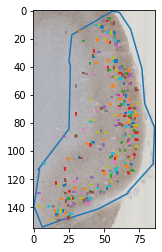

In [8]:
# Plotting the label along side the croped version of the whole slide image
# print(coords_region) # [c1, r1, c2, r2]
plt.figure()
plt.imshow(region)
for obj, coordinates in labels:
    # Moving the labels to the new region reference.
    plt.plot(coordinates[:, 0]-coords_region[0], coordinates[:, 1]-coords_region[1])
plt.show()


# Color Normalization
- Vahadane (Luminosity Standardize)
- Macenko (Luminosity Standardize)

In [1]:
import staintools

def normalize_alternative(image, ref, method, standartize_brightness):
    if standartize_brightness:
        image = staintools.LuminosityStandardizer.standardize(image)
        ref = staintools.LuminosityStandardizer.standardize(ref)
            
    if method == 'reinhard':
        normalizer = staintools.ReinhardColorNormalizer()
    if method == 'vahadane':
        normalizer = staintools.StainNormalizer(method='vahadane')
    if method == 'macenko':
        normalizer = staintools.StainNormalizer(method='macenko')
            
    normalizer.fit(ref)
    norm_img = normalizer.transform(image)
        
    return norm_img  

In [2]:
target = staintools.read_image("./output.png")

#print(target.dtype)
#print(np.array(region.convert('RGB')).astype(np.uint8).dtype)

In [3]:
#transformed_region = normalize_alternative(np.array(region.convert('RGB')).astype(np.uint8), target, 'macenko', True)
transformed_region = normalize_alternative(target, target, 'macenko', False)